## FOR COMP90024 ASSIGNMENT 2
### BY TEAM 45:
- William Chen 1400081
- Petr Andreev 1375858
- Rafsan Al Mamun 1407776
- Ojaswi Dheer 1447227

# Air Quality Analysis in Victoria
---------------------------------
This section of the notebook explores air quality data collected from various monitoring stations in Victoria. The dataset includes hourly average measurements of air quality parameters. The objective of this analysis is to gain insights into the temporal trends, spatial variations, and potential impacts of air pollution on public health in Victoria.

## Import Necessary Libraries:
----------------------------

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import folium
import sys
import time
from datetime import datetime

sys.path.append('../')
from backend.constants import *
import backend.querying.query_path_constants as query_constants

from api import * # see api.py

# Set display options for pandas DataFrame
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', 1000)        # Set display width

In [22]:
    
response = get_from_url_extension('/health', is_data=False)
elastic_status = response['status'] if response is not None else "Failed to fetch health"
print(f'Elastic Status: {elastic_status}')

Fetching from http://localhost:9090/health
Elastic Status: green


## Dataset Description:
--------------------

The dataset used in this analysis contains hourly average measurements of air quality parameters from various monitoring stations in Victoria. The dataset is sourced from EPA and includes the following columns:

- date: Date of observation
- time: Time of observation
- location_name: Name of the monitoring station
- latitude: Latitude coordinates of the monitoring station
- longitude: Longitude coordinates of the monitoring station
- value: Value of the observed air quality parameter
- parameter_name: Name of the observed air quality parameter

The objective of this analysis is to explore the relationship between air quality parameters and potential impacts on public health, particularly focusing on parameters such as CO (Carbon Monoxide), PM10 (Particulate Matter with diameter less than 10 micrometers), PM2.5 (Particulate Matter with diameter less than 2.5 micrometers), O3 (Ozone), and SO2 (Sulfur Dioxide). These parameters are known to have significant implications for air quality and human health.

## Data Preprocessing:
-------------------

Before delving into detailed analysis, it's crucial to preprocess the dataset to ensure its quality and suitability for further exploration:

1. Data Conversion: Convert the 'date' column to datetime format to facilitate temporal analysis.
2. Filtering: Apply filters to select specific air quality parameters of interest for focused analysis.

By performing these preprocessing steps, we can streamline the data and focus our analysis on the relevant air quality parameters, setting the foundation for insightful exploration.


## Data Examination:
-----------------

Before conducting detailed analysis, it's essential to perform initial checks and preparations on the dataset:

1. Summary Statistics: Compute summary statistics to understand the distribution and central tendencies of the data.

2. Missing Values: Check for any missing values in the dataset and handle them appropriately.

Let's proceed with examining the data to ensure its quality and suitability for analysis.


### Summary Statistics:
-----------------
By examining the summary statistics from various angles and considering their implications in the broader context of air quality management and public health, we can uncover valuable insights and inform evidence-based decision-making.

In [9]:
# Compute summary statistics for each parameter in 'parameter_name'

parameter_summary_stats = dataframe_from_url_ext(f'/data/air_quality/{query_constants.SUMMARY_STATS_BY_PARAM}').set_index('parameter_name')
print("Summary Statistics by Parameter:")
print(parameter_summary_stats)

Fetching from http://localhost:9090/data/air_quality/summary_stats_param
Summary Statistics by Parameter:
                count       mean        std        min       25%        50%        75%         max
parameter_name                                                                                    
CO              43966   0.167876   0.128601  -0.589000  0.095000   0.143767   0.205838    1.912000
O3              66467  16.296012   9.242869  -0.971000  9.937887  16.687075  22.497142   66.943001
PM10            56597  16.437867  11.658178 -19.612000  9.212370  13.907063  20.751261  416.869995
PM2.5           81045   5.775832   5.362274 -42.106998  2.466394   4.898970   8.033716   96.917999
SO2             49353   0.434215   1.719191  -5.458000 -0.070433   0.279761   0.678010  115.233002


### Insights from Summary Statistics:

1. Presence of Negative Values:
   The summary statistics reveal the presence of negative values for certain air quality parameters (e.g., CO, O3, PM10, PM2.5, SO2), indicating potential measurement errors or anomalies that require further investigation and data cleaning to ensure data quality.

2. Wide Range of Values:
   The wide range of values observed for each parameter suggests significant variability in air quality across different observations. This variability could be influenced by factors such as location, time of day, weather conditions, and human activities, highlighting the complex nature of air quality dynamics.

3. Extreme Values:
   Some parameters exhibit extreme maximum values (e.g., PM10, PM2.5, SO2), indicating the presence of outliers or highly polluted conditions in certain instances.

4. Differences in Central Tendencies:
   Notable differences in the central tendencies (mean, median) of air quality parameters indicate variations in data distribution. For example, a right-skewed distribution is observed for PM2.5 concentrations, with some high-value outliers influencing the mean.

5. Standard Deviation and Variability:
   Parameters with higher standard deviations (e.g., PM10, PM2.5) exhibit greater variability in concentrations, suggesting heterogeneous spatial and temporal patterns in air quality. This variability underscores the importance of considering local factors and temporal trends in air quality management efforts.

6. Comparative Analysis and Health Implications:
   Comparative analysis of summary statistics across parameters highlights differences in emission sources, atmospheric processes, and regional variability for various pollutants. Parameters exceeding regulatory limits or health guidelines may pose increased health risks to exposed populations, emphasizing the importance of air quality monitoring and mitigation measures.

## Exploratory Data Analysis (EDA):
-----------------------------------------

In this section, we delve deeper into the air quality dataset through various analytical approaches to gain valuable insights into air quality dynamics across different dimensions.

1. Distribution of Data Across Monitoring Locations:
   We start by visualizing the distribution of data across monitoring locations using a pie chart. This analysis provides an overview of the distribution of observations among different monitoring stations, offering insights into the spatial coverage of the dataset.

2. Comparative Analysis Across Locations:
   Next, we perform a comparative analysis to compare air quality parameters across different monitoring locations. Through box plots grouped by location and parameter, we explore spatial variations in air quality and investigate potential differences in pollution levels among monitoring stations.

3. Temporal Trend Analysis:
   Moving on, we conduct a temporal trend analysis to examine how air quality parameters vary over time. By calculating the monthly average of air quality parameters and visualizing the temporal trends, we aim to identify seasonal patterns and long-term trends in air quality dynamics.

4. Spatial Analysis:
Finally, we conduct a spatial analysis of the air quality data to visually analyse the spread of PM2.5 particles across Victoria. This will help us pinpoint locations of interest where there is a higher chance of lung-related disorders.

These analytical approaches provide valuable insights into the spatial, temporal, and parameter-wise variations in air quality, contributing to a comprehensive understanding of air quality dynamics in the study area.


### Distribution of Data Across Monitoring Locations:
----------------------
Let's plot a pie chart to check which locations have the most data available. However, since there are 20 locations in the dataset, viewing all of them will cause overlaps. So, we will group the data into major locations.

Moreover, not every location has values for the same group of pollutants. Hence, we will focus on only PM2.5 which is thought to be the most dangerous for lung diseases.

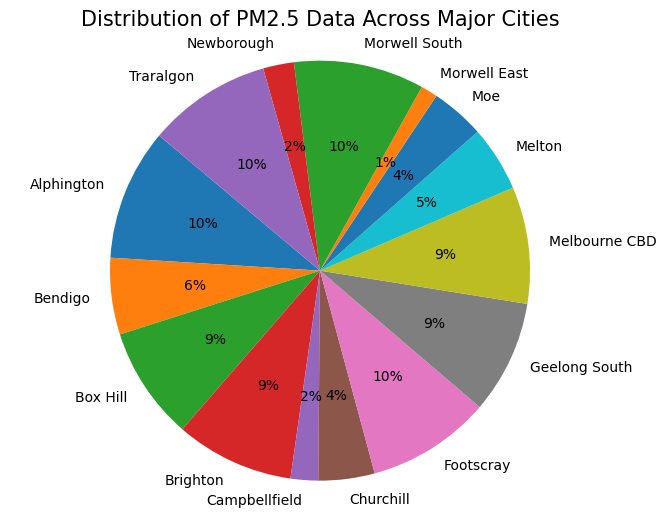

In [17]:
# Define the list of major cities

location_counts = dataframe_from_url_ext(f'/data/air_quality/{query_constants.DATA_DIST}')

# Create a pie chart with aggregated locations
plt.figure(figsize=(8, 6))
plt.pie(
    location_counts['row_count'], 
    labels=list(location_counts['location_name']), 
    autopct='%1.0f%%', 
    startangle=140
  )
plt.title('Distribution of PM2.5 Data Across Major Cities', fontsize=15, pad=10)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

### Insights from Data Distribution Chart:

1. Overall Picture:
The major cities account for about 51% of all the data related to PM2.5 particle in the dataset.

2. Urban Centers with Higher PM2.5 Levels:
Locations such as Melbourne CBD, Footscray, and Box Hill, with PM2.5 proportions ranging from 8.7% to 9.5%, likely correspond to urban centers or areas with higher population density and vehicular traffic. These areas typically experience elevated PM2.5 levels due to emissions from vehicles, industrial activities, and urban development.

3. Local Pollution Hotspots:
Locations like Brighton, known for their proximity to busy roads or industrial zones, have relatively higher proportions of PM2.5 data (9.1%). These areas may represent local pollution hotspots where emissions from transportation, industrial processes, or residential heating contribute to elevated PM2.5 levels.

### Distribution of PM2.5 Across Different Locations:
------------------------------
Next, let's have a look at the distribution of PM2.5 across the locations to explore spatial variations in air quality and investigate potential differences in pollution levels among monitoring stations.


In [19]:
summary_by_location = dataframe_from_url_ext(f'/data/air_quality/{query_constants.SUMMARY_STATS_BY_LOC}').set_index('location_name')
print(summary_by_location)


Fetching from http://localhost:9090/data/air_quality/summary_stats_loc
               count      mean       std        min       25%       50%       75%        max
location_name                                                                               
Alphington      8208  6.623458  6.360689 -16.077999  2.701110  5.596240  9.287361  70.568001
Bendigo         4778  3.321866  4.173556 -12.334000  0.631800  2.772077  5.361272  42.761002
Box Hill        7062  5.096341  5.760376  -9.004000  1.838316  4.156171  7.133632  96.917999
Brighton        7395  6.893843  5.934334 -10.695000  3.381176  5.847036  8.891016  70.307999
Campbellfield   1718  6.479662  5.769933  -4.838000  2.941887  5.453056  8.700498  54.264999
Churchill       3506  5.840987  5.057383  -5.780000  2.541217  5.178473  8.314650  41.492001
Footscray       7739  5.760731  4.947937  -7.860000  2.590141  4.944845  7.948371  46.202000
Geelong South   7068  4.395366  4.736730 -10.540000  1.531217  3.563190  6.204186  76.919998

From the summary statistics, it can be seen that there is a large dispersion (min/max value) of the data for each location from their measures of central tendency. Hence, there is a possibility of large outliers that might distort the boxplots for the distribution of PM2.5 across different locations, so we will plot the charts without these outliers.

data requested at 2024-05-20 01:25:04.996391
Fetching from http://localhost:9090/data/air_quality/stat_analysis
Time taken to fetch: 39.57719922065735


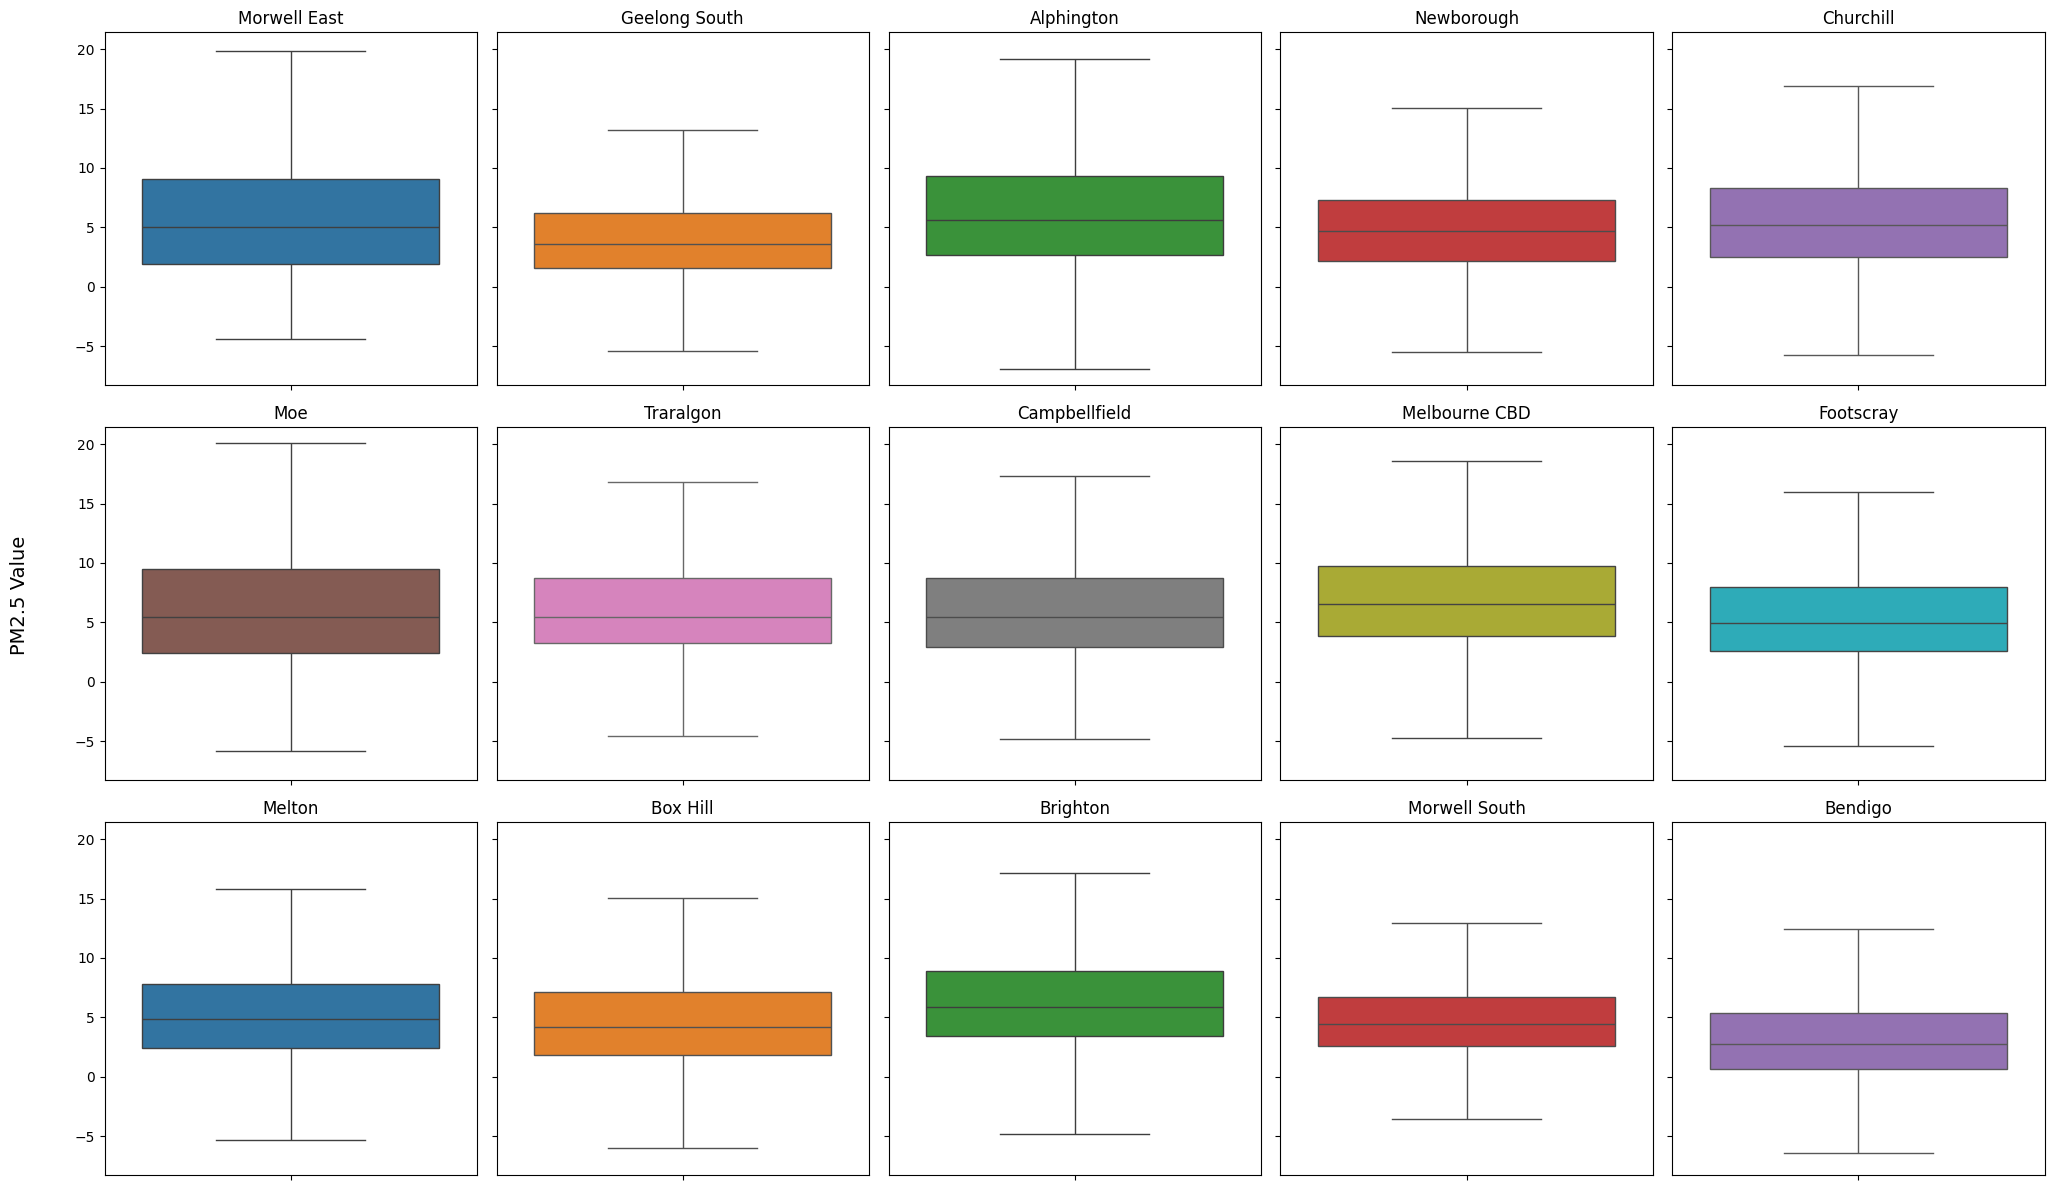

: 

In [42]:
start = time.time()
print(f'data requested at {datetime.now()}')
pm25_data = dataframe_from_url_ext(f'/data/air_quality/{query_constants.FOR_STATISTICAL_ANALYSIS}')
print(f'Time taken to fetch: {time.time() - start}')
unique_locations = pm25_data['location_name'].unique()

# Calculate number of rows and columns
num_locations = len(unique_locations)
num_rows = 3
num_cols = math.ceil(num_locations / num_rows)

# Define a custom color palette with enough distinct colors
palette = sns.color_palette('tab10', n_colors=num_locations)

# Create subplots for each location
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 12), sharey=True)

# Flatten axes array to handle both single and multiple subplots
axes = axes.flatten()

# Iterate over unique locations and create boxplots
for i, location in enumerate(unique_locations):
    sns.boxplot(y='value', data=pm25_data[pm25_data['location_name'] == location], ax=axes[i], color=palette[i], showfliers=False)
    axes[i].set_title(f'{location}')
    axes[i].set_ylabel('')

# Add shared y-axis label
fig.text(-0.02, 0.5, 'PM2.5 Value', ha='center', va='center', rotation='vertical', fontsize=14)

plt.tight_layout()
plt.show()

### Insights from PM2.5 Distribution Across Locations:

1. Variability:
There is considerable variability in PM2.5 levels across different locations, as indicated by the range of values and standard deviations. For instance, standard deviations range from approximately 3.70 µg/m³ to 6.36 µg/m³, suggesting differing levels of air pollution or local factors affecting PM2.5 concentrations.

2. Urban vs. Regional:
Urban areas like Melbourne CBD and Box Hill tend to have higher mean PM2.5 levels compared to regional areas like Bendigo and Traralgon. For example, Melbourne CBD exhibits a mean PM2.5 level of approximately 7.27 µg/m³, whereas Bendigo has a mean of about 3.32 µg/m³. This discrepancy suggests differing sources of pollution, including traffic congestion, industrial activities, and population density, influencing urban air quality.

3. Outliers:
Some locations exhibit outliers with extremely high or low PM2.5 values, as indicated by the minimum and maximum values. For instance, Box Hill shows a maximum PM2.5 value of approximately 96.92 µg/m³, while Morwell South has a minimum of around -42.11 µg/m³. These outliers may be indicative of unusual events or localized sources of pollution, warranting further investigation.

4. Temporal Patterns:
Although not explicitly shown here, examining temporal patterns in PM2.5 levels could provide additional insights. Seasonal variations, diurnal patterns, and trends over time may reveal underlying factors influencing air quality at different locations.


## Temporal Trend Analysis:
---------------------------
Next, we examine how PM2.5 levels vary over time to identify seasonal patterns and long-term trends in air quality dynamics. For that we will plot the hourly and monthly trends of PM2.5 across all locations.

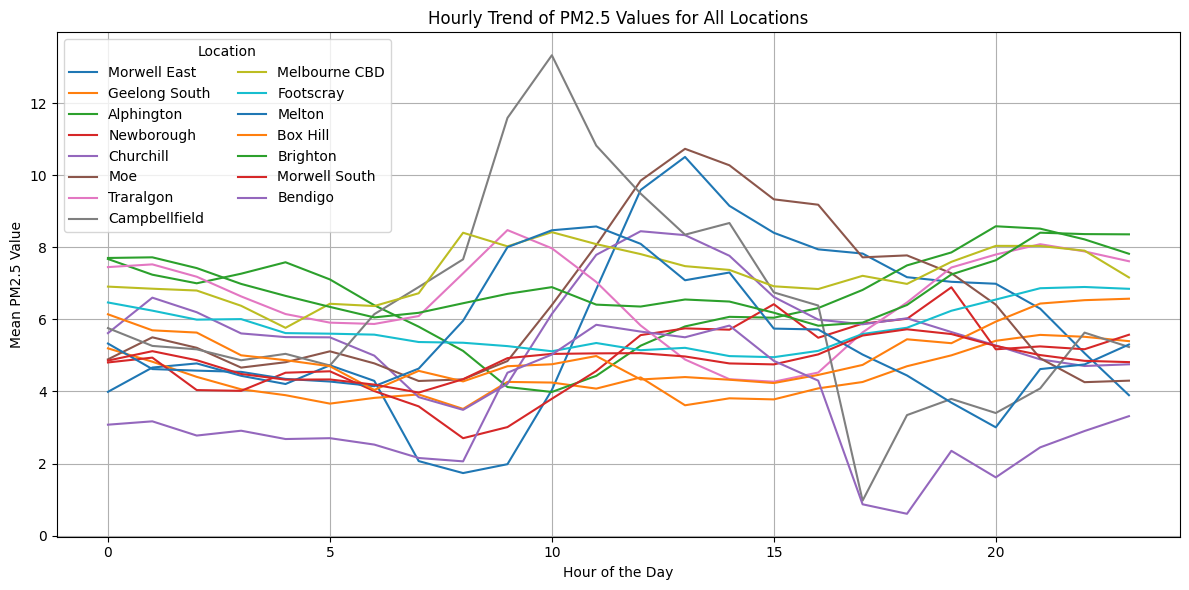

In [13]:
# Extract hour from time
# # Convert 'date' column to datetime data type
pm25_data['date'] = pd.to_datetime(pm25_data['date'])

pm25_data['time'] = pd.to_datetime(pm25_data['time'], format='%H:%M:%S')

# # Extract only the date portion from the datetime column
pm25_data['date'] = pm25_data['date'].dt.date

pm25_data.loc[:, 'hour'] = pm25_data['time'].apply(lambda x: x.hour)

# Plot hourly trend for all locations using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=pm25_data, x='hour', y='value', hue='location_name', errorbar=None, palette=palette)

plt.title('Hourly Trend of PM2.5 Values for All Locations')
plt.xlabel('Hour of the Day')
plt.ylabel('Mean PM2.5 Value')
plt.legend(title='Location', loc='upper left', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

### Insights from Hourly Trend of PM2.5 Across All Locations:

1. Impact of Human Activity:
Higher PM2.5 levels are observed during the day, indicating the influence of peak human activity hours. This may be attributed to increased traffic congestion, industrial operations, and energy consumption (e.g., from heating, cooking, and air conditioning), which release particulate matter into the air.

2. Influence of Meteorological Factors:
The plot suggests a significant role of atmospheric conditions in PM2.5 levels, with elevated concentrations observed during daylight hours. Factors such as temperature, sunlight, and wind patterns contribute to the dispersion and accumulation of pollutants, leading to higher pollution levels during the day.

3. Patterns in Emissions:
Diurnal variations in PM2.5 levels are evident, suggesting different emission patterns throughout the day. Activities such as rush-hour traffic and industrial production may result in increased emissions during daytime hours, impacting air quality.

4. Regional and Local Variations:
Spatial and temporal variability in PM2.5 concentrations is observed, influenced by regional and local factors such as geographical location, urbanization, and proximity to emission sources. These factors contribute to the observed hourly trends in PM2.5 values across different locations.


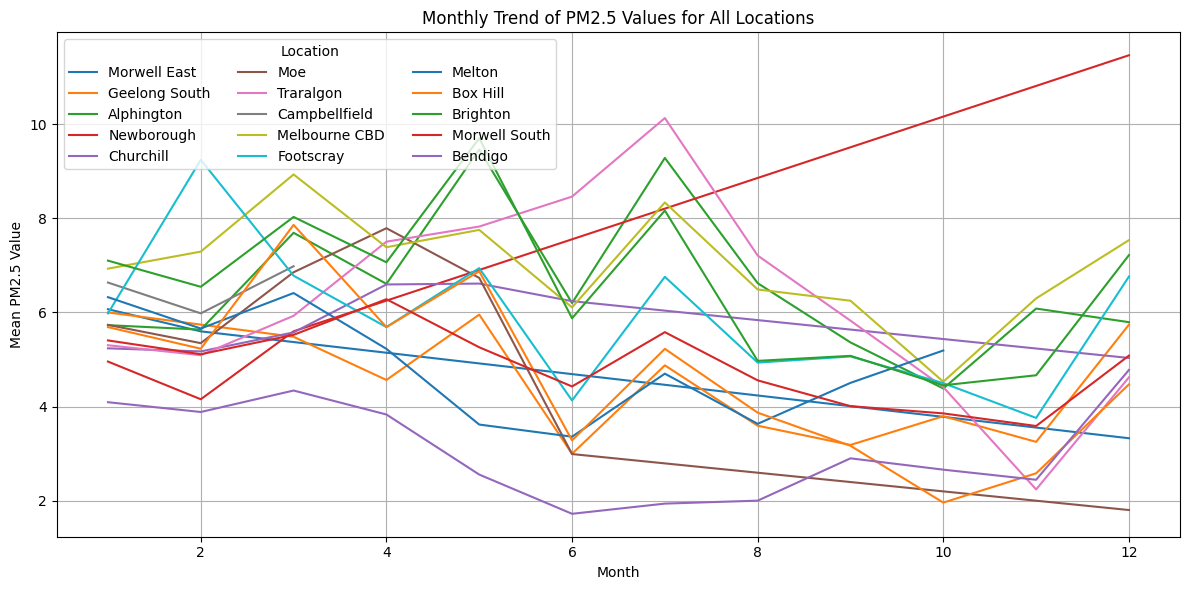

In [14]:
# Extract month from date
pm25_data.loc[:, 'month'] = pm25_data['date'].apply(lambda x: x.month)

# Plot monthly trend for all locations using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=pm25_data, x='month', y='value', hue='location_name', errorbar=None, palette=palette)

plt.title('Monthly Trend of PM2.5 Values for All Locations')
plt.xlabel('Month')
plt.ylabel('Mean PM2.5 Value')
plt.legend(title='Location', loc='upper left', ncol=3)

plt.grid(True)
plt.tight_layout()
plt.show()


### Insights from Monthly Trend of PM2.5 Across All Locations:

1. Seasonal Transitions:
The observed increase in PM2.5 values between March and August may coincide with transitional seasons. Weather phenomena such as temperature inversions, where a layer of warm air traps cooler air close to the ground, can occur more frequently during autumn and winter in Victoria. Inversion events can lead to the stagnation of pollutants near the surface, resulting in higher PM2.5 levels, especially in urban areas with high emissions.

2. Wood Burning and Heating:
Cooler temperatures during autumn and winter may lead to increased use of wood heaters and fireplaces for residential heating purposes. Wood combustion emits particulate matter and other pollutants, which can contribute to higher PM2.5 concentrations, particularly in urban and rural areas.

3. Industrial and Urban Sources:
Autumn and winter months may see increased industrial and urban activities, which can emit pollutants such as PM2.5. Factors such as increased energy demand, industrial production, and vehicular traffic in response to cooler temperatures may contribute to higher PM2.5 concentrations during this period.

4. Always Increasing Trend of Newborough:
Coal-fired power plants like Yallourn can be significant sources of particulate matter (including PM2.5) emissions, and there has been rising safety concerns surrounding this plant over the last few years.

Based on both the hourly and monthly trends, it seems like Churchill might be a safe place to live in regard to PM2.5 pollution as it sees the lowest overall exposure to the pollutant. Such low levels of PM2.5 can reduce the chances of contracting lung diseases.


## Spatial Analysis:
------------------------
Finally, we conduct a spatial analysis of the air quality data to visually analyse the spread of PM2.5 particles across Victoria. This will help us pinpoint locations of interest where there is a higher chance of lung-related disorders.

In [16]:
# Group by suburb, parameter_name, and month, average sum the values
summed_data = dataframe_from_url_ext(f'/data/air_quality/{query_constants.FOR_SPATIAL_ANALYSIS}')
summed_data.head()

Fetching from http://localhost:9090/data/air_quality/spatial_analysis


,location_name,parameter_name,latitude,longitude,value
0,Alphington,PM2.5,-37.778408,145.030600,6.618976
1,Bendigo,PM2.5,-36.778400,144.300069,3.314946
2,Box Hill,PM2.5,-37.828728,145.132400,5.085474
3,Brighton,PM2.5,-37.913547,144.998000,6.884526
4,Campbellfield,PM2.5,-37.679276,144.965717,6.466670


In [17]:
map_center = [-37.82, 145.4]
# Create a map centered around Melbourne
map_melbourne = folium.Map(location=map_center, zoom_start=9, width=1000, height=1000)

# Add title to the map
title_html = '<h3 align="center" style="font-size:25px"><b>Air Quality (PM2.5) in Victoria</b></h3>'
map_melbourne.get_root().html.add_child(folium.Element(title_html))

# Define a colormap
colormap = folium.LinearColormap(colors=['orange', 'red', 'black'],
                                  vmin=summed_data['value'].min(),
                                  vmax=summed_data['value'].max(),
                                  caption='PM2.5')


# Add CircleMarkers for each location
for index, row in summed_data.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['value'] * 3,
        color=colormap(row['value']),
        fill=True,
        fill_color=colormap(row['value']),
        fill_opacity=0.7,
        popup=folium.Popup(f"{row['location_name']}: PM2.5 = {row['value']:.1f}", parse_html=True),
    ).add_to(map_melbourne)

    # Add PM2.5 values inside CircleMarkers
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        icon=folium.DivIcon(html=f"<div style='font-size: 8pt; color: white;'>{row['value']:.1f}</div>"),
        icon_anchor=(0, 0)
    ).add_to(map_melbourne)

# Add the color scale
colormap.add_to(map_melbourne)

# Display the map
map_melbourne


### Insights from Spatial Analysis:

Here are some insights into why this could be the case:

- **Urbanization and Population Density:**
Greater Melbourne tends to have higher population density and more industrial activities compared to other regions of Victoria. These factors contribute to higher levels of PM2.5 emissions.
Suburbs within Greater Melbourne such as Alphington, Box Hill, Brighton, Campbellfield, Footscray, Melbourne CBD, and Melton consistently show higher PM2.5 levels compared to suburbs in the rest of Victoria.

- **Industrial Activities and Traffic:**
Areas with more industrial activities and higher traffic tend to have higher levels of PM2.5 due to emissions from vehicles, factories, and other sources.
Suburbs like Melbourne CBD, Campbellfield, and Footscray, being commercial and industrial centers, exhibit higher PM2.5 levels.

- **Geographical Factors:**
Geography and weather patterns can also influence PM2.5 levels. Coastal areas might experience lower levels due to cleaner air coming in from the ocean.
Suburbs like Bendigo, Geelong South, Churchill, Moe, Morwell East, Morwell South, Newborough, and Traralgon, being located outside Greater Melbourne, tend to have lower PM2.5 levels.
\end{enumerate}

# Lung Disease Analysis in Victoria
---------------------------------
This section of the notebook explores lung disease data collected from SUDO across all of Australia. The dataset includes mortality rates, income levels, employment status, gender etc for asthma and COPD. The objective of this analysis is to gain insights into the relationship of demographics with lung diseases.

## Load the Dataset:
--------------------

There are several datasets for this analysis that contains statistics for lung diseases across various factors.

Before proceeding with the analysis, we will load all the datasets.

In [4]:
male_lung_cancer_data = dataframe_from_url_ext(f'/data/{MORTALITY_MALES}/all')

female_lung_cancer_data = dataframe_from_url_ext(f'/data/{MORTALITY_FEMALES}/all')

all_lung_cancer_data = dataframe_from_url_ext(f'/data/{MORTALITY_PERSONS}/all')

census_by_cob_data = dataframe_from_url_ext(f'/data/{ASTHMA_BY_REGION_INDEX_NAME}/all')

census_by_inc_emp_data = dataframe_from_url_ext(f'/data/{CENSUS_G21B}/all')

Fetching from http://localhost:9090/data/mortality_males/all
Fetching from http://localhost:9090/data/mortality_females/all
Fetching from http://localhost:9090/data/mortality_persons/all
Fetching from http://localhost:9090/data/asthma_by_region/all
Fetching from http://localhost:9090/data/census_g21b/all


In [10]:
census_by_cob_data.to_dict(orient='split')

{'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 'columns': ['australian asthma',
  'australian copd',
  'employed asthma',
  'foreigner asthma',
  'foreigner copd',
  'gccsa_code',
  'gccsa_name',
  'total asthma',
  'total copd'],
 'data': [[263188,
   40132,
   176461,
   88368,
   21806,
   '1GSYD',
   'Greater Sydney',
   353656,
   63101],
  [246105, 60438, 122833, 21667, 9994, '1RNSW', 'Rest of NSW', 271403, 72543],
  [292521,
   37523,
   208830,
   91496,
   20287,
   '2GMEL',
   'Greater Melbourne',
   386347,
   58925],
  [140299, 31287, 73533, 13405, 5734, '2RVIC', 'Rest of Vic', 156014, 38195],
  [182163,
   35004,
   116657,
   40601,
   11007,
   '3GBRI',
   'Greater Brisbane',
   224233,
   46859],
  [181605, 46620, 102552, 29017, 11730, '3RQLD', 'Rest of Qld', 212875, 59756],
  [99461,
   17031,
   60136,
   20816,
   7994,
   '4GADE',
   'Greater Adelaide',
   121331,
   25546],
  [33572, 8168, 16482, 3384, 1916, '4RSAU', 'Rest of SA', 37619, 10432],
  [

## Summary Statistics:
-----------------
By examining the summary statistics from various angles and considering their implications in the broader context of lung diseases across the country, we can uncover valuable insights and inform evidence-based decision-making.

Here we will visualise the descriptive statistics for asthma and COPD prevalence and the mortality associated with lung cancer.

In [7]:
# Merge mortality and census datasets based on location
merged_data_1 = all_lung_cancer_data.merge(census_by_cob_data, how='inner', on=['gccsa_code', 'gccsa_name'])
merged_data_1.head()

,all_cancer_population,all_cancer_total_mortality,gccsa_code,gccsa_name,lung_cancer_population,lung_cancer_rate_per_100k,lung_cancer_total_mortality,australian asthma,australian copd,employed asthma,foreigner asthma,foreigner copd,total asthma,total copd
0,23089361,39171,1GSYD,Greater Sydney,23089361,31.50,7272,263188,40132,176461,88368,21806,353656,63101
1,13043735,33277,1RNSW,Rest of NSW,13043735,49.93,6513,246105,60438,122833,21667,9994,271403,72543
2,20904141,35887,2GMEL,Greater Melbourne,20904141,30.51,6377,292521,37523,208830,91496,20287,386347,58925
3,6834239,17475,2RVIC,Rest of Vic,6834239,45.92,3138,140299,31287,73533,13405,5734,156014,38195
4,10753623,18039,3GBRI,Greater Brisbane,10753623,31.67,3406,182163,35004,116657,40601,11007,224233,46859


In [4]:
# Merge mortality and census datasets based on location
merged_data_1 = dataframe_from_url_ext(f'/data/air_quality/{query_constants.COB_CANCER_MERGE}')
merged_data_1.head()

Fetching from http://localhost:9090/data/air_quality/persons_merged_with_COB


In [8]:
# Display summary stats of chosen columns
merged_data_1[['total asthma', 'total copd', 'lung_cancer_total_mortality']].describe()

,total asthma,total copd,lung_cancer_total_mortality
count,15.000000,15.000000,15.000000
mean,137608.066667,29331.933333,2690.866667
std,127839.516274,25478.827755,2505.530536
min,4429.000000,942.000000,137.000000
25%,34008.500000,7573.500000,585.000000
50%,121331.000000,25546.000000,2506.000000
75%,218554.000000,52892.000000,4017.000000
max,386347.000000,72543.000000,7272.000000


### Insights from Summary Statistics:
1. High Variability in Asthma Prevalence:
The diagnosed cases of asthma exhibit significant variability across different locations in Australia. The standard deviation of approximately 127,840 individuals highlights substantial differences in asthma prevalence between regions.

2. Asthma Burden and Disease Impact:
The mean number of diagnosed asthma cases (137,608 individuals) suggests a considerable burden of asthma within the population. This underscores the importance of public health interventions and access to effective asthma management strategies.

3. Comparison with COPD Prevalence:
While COPD has a lower mean prevalence (29,332 individuals) compared to asthma, it still represents a significant health concern with notable variation between locations (std ≈ 25,479 individuals). COPD poses challenges in healthcare delivery and emphasizes the need for targeted prevention and treatment approaches.

4. Geographical Variations:
The wide range of diagnosed cases for both asthma (4,429 to 386,347 individuals) and COPD (942 to 72,543 individuals) reflects geographical disparities in disease prevalence. Understanding regional differences can inform targeted healthcare policies and resource allocation.

5. Public Health Implications:
The distribution analysis, including quartile breakdowns, provides insights into the distribution of disease burden within each category. This information is crucial for prioritizing resources and interventions to address asthma and COPD at local and national levels.

## Exploratory Data Analysis (EDA):
-----------------------------------

### Distribution of Data Across Locations:
-----------------------------------
Let's plot some pie charts to see the distribution of asthma and COPD prevalence and lung cancer mortality.

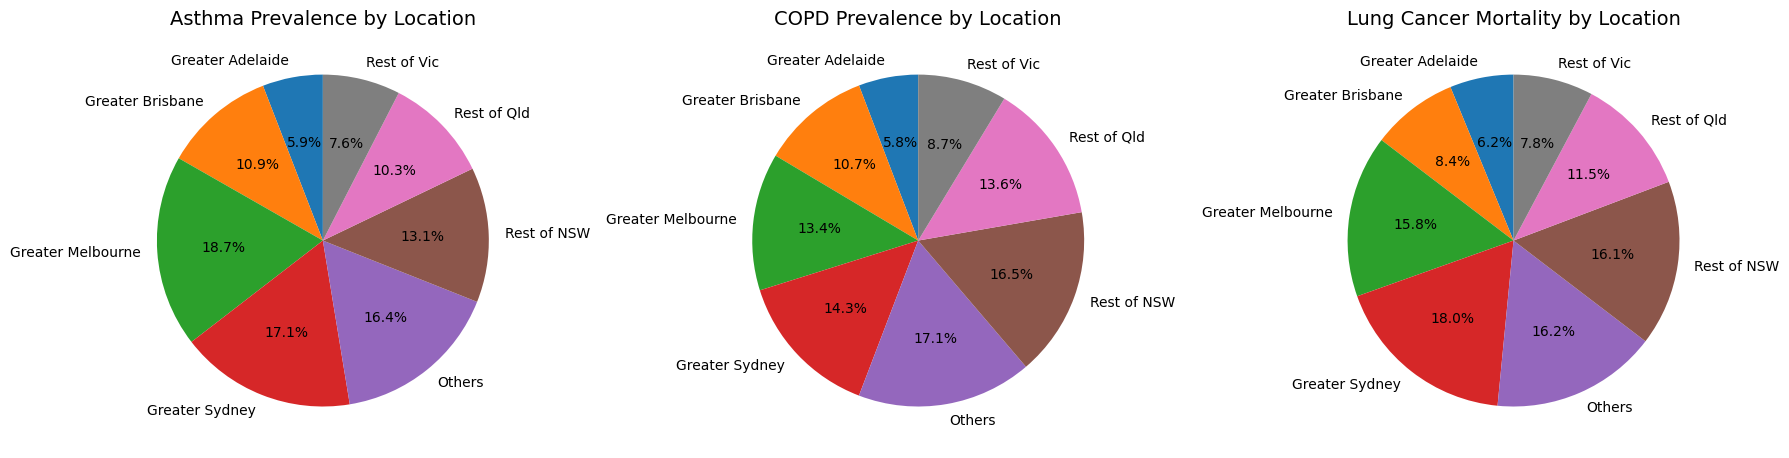

In [9]:
# Major locations
major_locations = ['Greater Melbourne', 'Greater Sydney', 'Greater Brisbane', 'Greater Adelaide', 'Rest of Vic', 'Rest of NSW', 'Rest of Qld']

# Define the aggregation function
def aggregate_locations(location):
    if location in major_locations:
        return location
    else:
        return 'Others'

# Apply the aggregation function to create a new column 'aggregated_location'
merged_data_1.loc[:, 'aggregated_location'] = merged_data_1['gccsa_name'].apply(aggregate_locations)

# Filter data for pie charts (include only major locations and "Others")
filtered_data2 = merged_data_1.groupby('aggregated_location')[['total asthma', 'total copd', 'lung_cancer_total_mortality']].sum()

# Create subplots for pie charts
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 12))

# Plot pie chart for Asthma prevalence
ax1.pie(filtered_data2['total asthma'], labels=filtered_data2.index, autopct='%1.1f%%', startangle=90)
ax1.set_title('Asthma Prevalence by Location', fontsize=14)

# Plot pie chart for COPD prevalence
ax2.pie(filtered_data2['total copd'], labels=filtered_data2.index, autopct='%1.1f%%', startangle=90)
ax2.set_title('COPD Prevalence by Location', fontsize=14)

# Plot pie chart for Lung Cancer mortality
ax3.pie(filtered_data2['lung_cancer_total_mortality'], labels=filtered_data2.index, autopct='%1.1f%%', startangle=90)
ax3.set_title('Lung Cancer Mortality by Location', fontsize=14)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Insights from Distribution Charts:

1. Urban Air Quality and Environmental Factors:
- Higher Pollution Levels in Urban Centers: Major cities like Greater Sydney (17.1% asthma, 14.3% COPD) and Greater Melbourne (18.7% asthma, 13.4% COPD) experience elevated levels of air pollution due to industrial activities and vehicular emissions. Poor air quality can exacerbate respiratory conditions, leading to higher prevalence rates compared to regional areas with cleaner air.
- Impact of Geographic Features: Coastal cities such as Greater Brisbane (10.9% asthma, 10.7% COPD) may benefit from milder climates and lower levels of pollution, contributing to relatively lower prevalence rates compared to inland cities.

2. Population Density and Lifestyle Factors:
- Urban Lifestyle and Health Impacts: Urban residents often face sedentary lifestyles, higher stress levels, and dietary habits that can contribute to respiratory issues. The higher population density in major cities may also increase the spread of respiratory infections, influencing disease prevalence.
- Healthcare Access and Awareness: Major cities like Greater Sydney and Greater Melbourne have better access to healthcare services and resources, resulting in higher diagnosis rates of respiratory conditions. Increased awareness and proactive healthcare-seeking behaviors contribute to higher reported prevalence rates.

3. Climate and Weather Conditions:
- Allergens and Seasonal Patterns: Differences in allergen exposure and seasonal variations can affect asthma prevalence. Regions with specific allergen profiles or seasonal triggers may experience higher rates of asthma.

4. Demographic and Socioeconomic Factors:
- Population Age and Socioeconomic Status: Regions with older populations or lower socioeconomic status (e.g., Rest of NSW - 13.1% asthma, 16.5% COPD) may exhibit higher prevalence rates due to factors such as smoking rates and occupational exposures.
- Rural Health Challenges: Regional areas face challenges related to healthcare access and infrastructure, impacting disease detection and management.

### Lung Cancer Prevalence by Gender and Location:
---------------------------------
Next, let's visualise lung cancer prevalence rates based on gender across multiple locations. The grouped bar chart below compares the prevalence rates of lung cancer between males and females in different geographical areas, providing insights into potential gender disparities in lung cancer incidence.

In [22]:
# Merge the male and female lung cancer datasets based on location
merged_data_2 = male_lung_cancer_data[['gccsa_name', 'lung_cancer_rate_per_100k']].merge(female_lung_cancer_data[['gccsa_name', 'lung_cancer_rate_per_100k']], how='inner', on='gccsa_name', suffixes=('_male', '_female'))

merged_data_2.head()

,gccsa_name,lung_cancer_rate_per_100k_male,lung_cancer_rate_per_100k_female
0,Greater Sydney,37.96,25.14
1,Rest of NSW,61.25,38.71
2,Greater Melbourne,36.72,24.44
3,Rest of Vic,56.77,35.15
4,Greater Brisbane,38.57,24.84


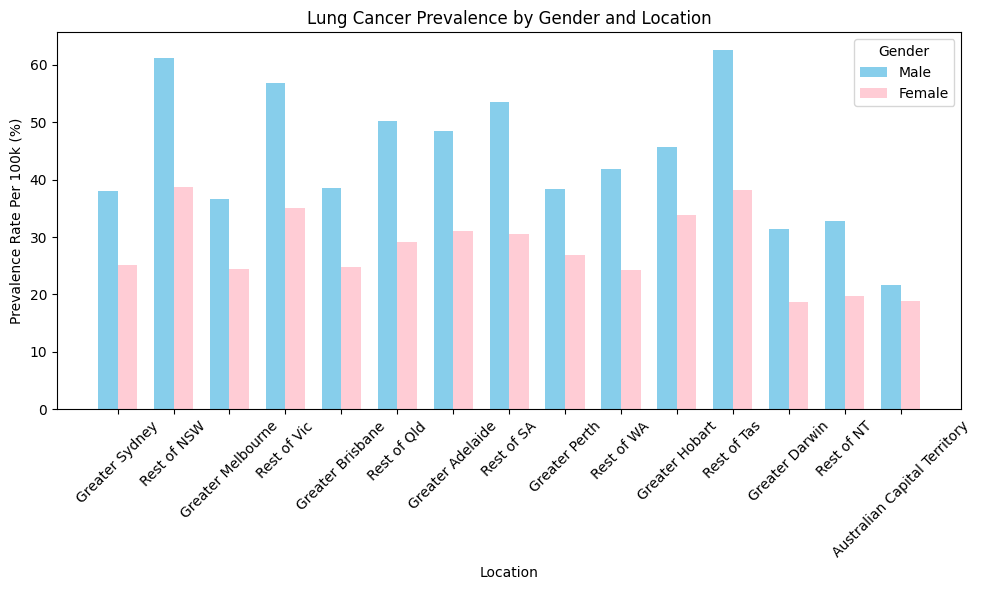

In [23]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Plot clustered bar chart
bar_width = 0.35
index = np.arange(len(merged_data_2))

# Plot bars for male and female prevalence rates
plt.bar(index, merged_data_2['lung_cancer_rate_per_100k_male'], width=bar_width, label='Male', color='skyblue')
plt.bar(index + bar_width, merged_data_2['lung_cancer_rate_per_100k_female'], width=bar_width, label='Female', color='pink', alpha=0.8)

# Customize labels and ticks
plt.xlabel('Location')
plt.ylabel('Prevalence Rate Per 100k (%)')
plt.title('Lung Cancer Prevalence by Gender and Location')
plt.xticks(index + bar_width / 2, merged_data_2['gccsa_name'], rotation=45)  # Center x-ticks between bars
plt.legend(title='Gender')

# Show plot
plt.tight_layout()
plt.show()

### Insights from Lung Cancer Prevalence by Gender and Location:

1. Regional Disparities in Lung Cancer Prevalence:
The data highlights significant regional variations in lung cancer prevalence rates. For instance, regions such as 'Rest of NSW' exhibit a notably higher average prevalence rate of 61.25 per 100,000 population for males and 38.71 per 100,000 population for females, compared to major urban centers like 'Greater Sydney' with 37.96 per 100,000 population for males and 25.14 per 100,000 population for females.

2. Gender Discrepancies in Prevalence Rates:
Across most regions, males consistently demonstrate higher lung cancer prevalence rates than females. Notable discrepancies are observed in locations like 'Rest of Vic', where the male prevalence rate reaches 56.77 per 100,000 population compared to 35.15 per 100,000 population for females.

3. Urban-Rural Contrasts:
The data suggests a trend of elevated lung cancer prevalence rates in rural and regional areas compared to major metropolitan regions. For example, 'Rest of Qld' demonstrates 50.17 per 100,000 population for males and 29.07 per 100,000 population for females, whereas 'Greater Brisbane' has 38.57 per 100,000 population for males and 24.84 per 100,000 population for females.

4. Region-Specific Observations:
Noteworthy observations include heightened prevalence rates in Tasmania ('Rest of Tas') with 62.54 per 100,000 population for males and 38.24 per 100,000 population for females, alongside relatively lower rates in the Australian Capital Territory ('Australian Capital Territory') with 21.74 per 100,000 population for males and 18.91 per 100,000 population for females.

5. Lower Prevalence Rates in Urban Centers:
Major cities such as 'Greater Sydney', 'Greater Melbourne', and 'Greater Brisbane' exhibit comparatively lower lung cancer prevalence rates. For instance, 'Greater Sydney' reports 37.96 per 100,000 population for males and 25.14 per 100,000 population for females, suggesting potential differences in lifestyle factors or healthcare access.


### Prevalence of Asthma and COPD by Income Level:
---------------------------------
Next, we will use boxplots to visualize the prevalence of asthma and COPD (Chronic Obstructive Pulmonary Disease) across different weekly income levels. Boxplots are effective for understanding the distribution of prevalence rates within each income category, highlighting potential disparities or trends based on socioeconomic factors.

The analysis will provide insights into how asthma and COPD prevalence vary across income brackets, aiding in the identification of potential socioeconomic determinants of respiratory health conditions.

C:\Users\kiwit\AppData\Local\Temp\ipykernel_10416\2843153372.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(income_labels)
C:\Users\kiwit\AppData\Local\Temp\ipykernel_10416\2843153372.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(income_labels)


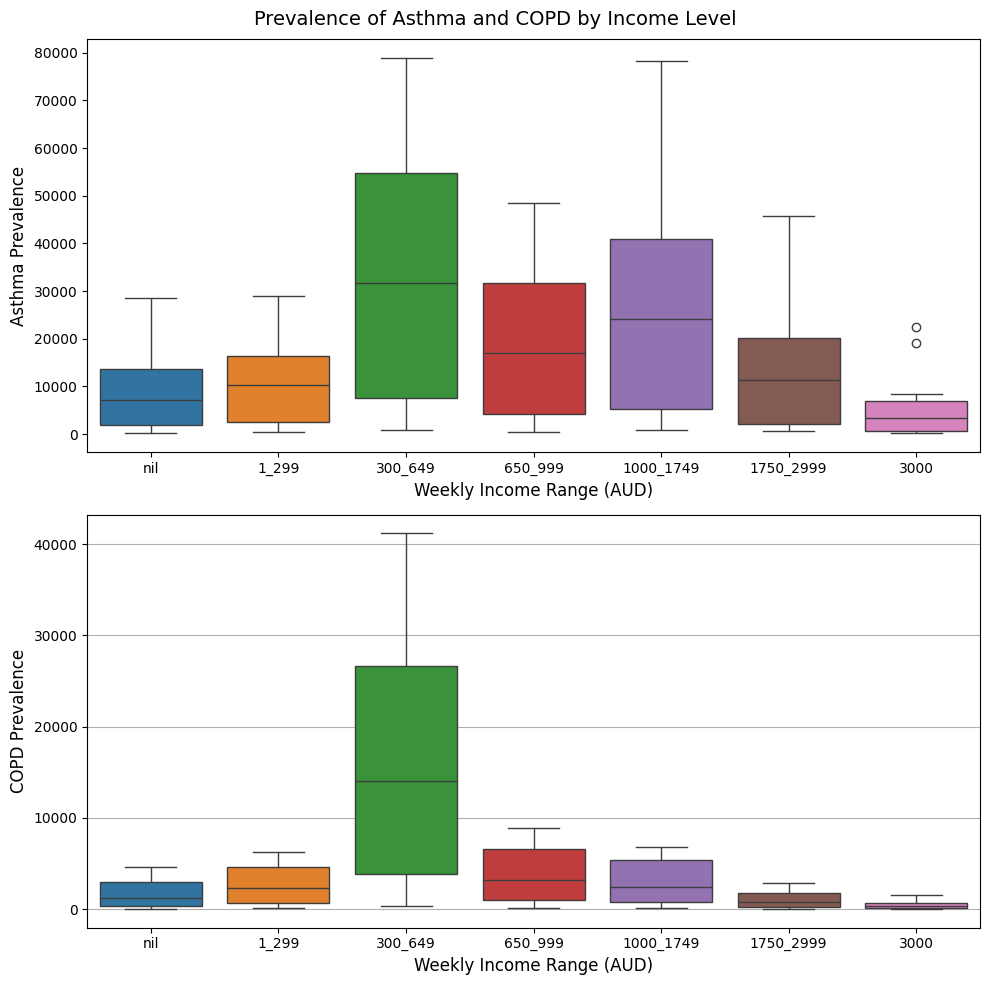

In [24]:
# Get required subsets of data
asthma_data = census_by_inc_emp_data[['weekly_income_nil_asthma', 'weekly_income_1_299_asthma', 'weekly_income_300_649_asthma', 'weekly_income_650_999_asthma', 'weekly_income_1000_1749_asthma', 'weekly_income_1750_2999_asthma', 'weekly_income_3000_asthma']]
copd_data = census_by_inc_emp_data[['weekly_income_nil_copd', 'weekly_income_1_299_copd', 'weekly_income_300_649_copd', 'weekly_income_650_999_copd', 'weekly_income_1000_1749_copd', 'weekly_income_1750_2999_copd', 'weekly_income_3000_copd']]

# Preprocess column names to extract the desired label
income_labels = [col.strip('weekly_income').strip('_asthma').strip('_copd') for col in asthma_data.columns]
income_labels[0] = 'nil'

# Create subplots for each disease
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the boxes
sns.boxplot(data=asthma_data, palette='tab10', ax=axes[0])
axes[0].set_ylabel('Asthma Prevalence', fontsize=12)
axes[0].set_xlabel('Weekly Income Range (AUD)', fontsize=12)
axes[0].set_xticklabels(income_labels)

sns.boxplot(data=copd_data, palette='tab10', ax=axes[1])
axes[1].set_ylabel('COPD Prevalence', fontsize=12)
axes[1].set_xlabel('Weekly Income Range (AUD)', fontsize=12)
axes[1].set_xticklabels(income_labels)

# Add title
plt.suptitle('Prevalence of Asthma and COPD by Income Level', fontsize=14)

# Add gridlines along the y-axis
plt.grid(axis='y')

plt.tight_layout()
plt.show()

### Insights from Asthma and COPD Prevalence by Income Level:

- Asthma Prevalence by Weekly Income Level:
    - Mean Prevalence: The highest mean prevalence of asthma is observed in the income range of "Weekly income (300-649) asthma" with a mean value of approximately 32,445 cases, followed by "Weekly income (1750-2999) asthma" and "Weekly income (1000-1749) asthma" with mean values of 25,758 and 14,336 cases, respectively.
    - Variability: The standard deviation (std) is relatively high across all income levels, indicating significant variability in asthma prevalence within each income category.
    - Distribution: The range of asthma prevalence spans from a minimum of around 196 cases (in "Weekly income (nil) asthma") to a maximum of approximately 78,964 cases (in "Weekly income (300-649) asthma"), highlighting considerable variation in asthma rates across income groups.

- COPD Prevalence by Weekly Income Level:
    - Mean Prevalence: The highest mean prevalence of COPD is observed in the income range of "Weekly income (300-649) COPD" with a mean value of approximately 15,446 cases, followed by "Weekly income (1000-1749) COPD" and "Weekly income (1750-2999) COPD" with mean values of 2,951 and 1,021 cases, respectively.
    - Variability: Similar to asthma, there is notable variability in COPD prevalence within each income category, as indicated by the standard deviation values.
    - Distribution: The range of COPD prevalence varies widely across income levels, with a minimum of approximately 43 cases (in "Weekly income (nil) COPD") and a maximum of around 41,176 cases (in "Weekly income (300-649) COPD").

1. Income Disparities in Respiratory Health:
The data suggests that individuals in lower income brackets (such as "Weekly income (nil)") exhibit lower mean prevalence of asthma and COPD compared to those in higher income ranges. This observation may reflect disparities in access to healthcare services, resulting in fewer diagnoses.

2. Financial Impact on Disease Burden:
Higher mean prevalence of asthma and COPD in specific income ranges (e.g., "Weekly income (300-649)" for asthma and COPD) could indicate a significant burden of respiratory diseases among individuals with moderate income levels. This finding underscores the potential financial implications of managing chronic respiratory conditions for individuals and healthcare systems.

3. Healthcare Access and Prevention:
Variability in asthma and COPD prevalence within income categories highlights the need for targeted healthcare interventions. Individuals with lower incomes may face barriers to accessing preventive care, early diagnosis, and treatment for respiratory conditions, leading to higher prevalence rates.

4. Policy and Public Health Interventions:
Addressing disparities in respiratory health requires holistic approaches that consider socioeconomic factors. Policy initiatives aimed at improving income equality, enhancing access to healthcare services, and promoting healthy environments can help mitigate disparities in asthma and COPD prevalence.

# Correlation Analysis between Air Quality (PM2.5) and Lung Disease
---------------------------------
Now that all exploratory data analysis is done, we will focus on the correlation between air quality, especially PM2.5, and lung-related disorders among the population in Victoria.

In [25]:
# lung_cancer
lung_cancer_df = merged_data_1[merged_data_1['gccsa_code'].isin(['2GMEL', '2RVIC'])]

In [26]:
region_map = {
    'Alphington': 'Greater Melbourne',
    'Bendigo': 'Rest of Vic',
    'Box Hill': 'Greater Melbourne',
    'Brighton': 'Greater Melbourne',
    'Campbellfield': 'Greater Melbourne',
    'Churchill': 'Rest of Vic',
    'Footscray': 'Greater Melbourne',
    'Geelong South': 'Rest of Vic',
    'Melbourne CBD': 'Greater Melbourne',
    'Melton': 'Greater Melbourne',
    'Moe': 'Rest of Vic',
    'Morwell East': 'Rest of Vic',
    'Morwell South': 'Rest of Vic',
    'Newborough': 'Rest of Vic',
    'Traralgon': 'Rest of Vic'
}

In [27]:
pm25_df = summed_data[['location_name', 'value']].copy()
pm25_df.rename(columns={'value': 'PM2.5'}, inplace=True)

# Map region to the PM2.5 dataframe
pm25_df.loc[:, 'region'] = pm25_df['location_name'].map(region_map)
pm25_df

,location_name,PM2.5,region
0,Alphington,6.618976,Greater Melbourne
1,Bendigo,3.314946,Rest of Vic
2,Box Hill,5.085474,Greater Melbourne
3,Brighton,6.884526,Greater Melbourne
4,Campbellfield,6.466670,Greater Melbourne
5,Churchill,5.828795,Rest of Vic
6,Footscray,5.742341,Greater Melbourne
7,Geelong South,4.370718,Rest of Vic
8,Melbourne CBD,7.259834,Greater Melbourne
9,Melton,5.511112,Greater Melbourne


In [28]:
# Group by region and calculate the mean of PM2.5 values
pm25_aggregated = pm25_df.groupby(['region'])['PM2.5'].mean().reset_index()  ##
pm25_aggregated

,region,PM2.5
0,Greater Melbourne,6.224133
1,Rest of Vic,5.275704


In [29]:
merged_df = pd.merge(lung_cancer_df, pm25_aggregated, left_on='gccsa_name', right_on='region', how='inner')
merged_df

,all_cancer_population,all_cancer_total_mortality,gccsa_code,gccsa_name,lung_cancer_population,lung_cancer_rate_per_100k,lung_cancer_total_mortality,australian asthma,australian copd,employed asthma,foreigner asthma,foreigner copd,total asthma,total copd,aggregated_location,region,PM2.5
0,20904141,35887,2GMEL,Greater Melbourne,20904141,30.51,6377,292521,37523,208830,91496,20287,386347,58925,Greater Melbourne,Greater Melbourne,6.224133
1,6834239,17475,2RVIC,Rest of Vic,6834239,45.92,3138,140299,31287,73533,13405,5734,156014,38195,Rest of Vic,Rest of Vic,5.275704


In [30]:
columns_list = [
    'gccsa_name',
    'lung_cancer_total_mortality',
    'all_cancer_total_mortality',
    'total copd',
    'australian copd',
    'foreigner asthma',
    'foreigner copd'
]
df_plot = merged_df[columns_list]
pm25_df.rename(columns={'value': 'PM2.5'}, inplace=True)

df_plot

,gccsa_name,lung_cancer_total_mortality,all_cancer_total_mortality,total copd,australian copd,foreigner asthma,foreigner copd
0,Greater Melbourne,6377,35887,58925,37523,91496,20287
1,Rest of Vic,3138,17475,38195,31287,13405,5734


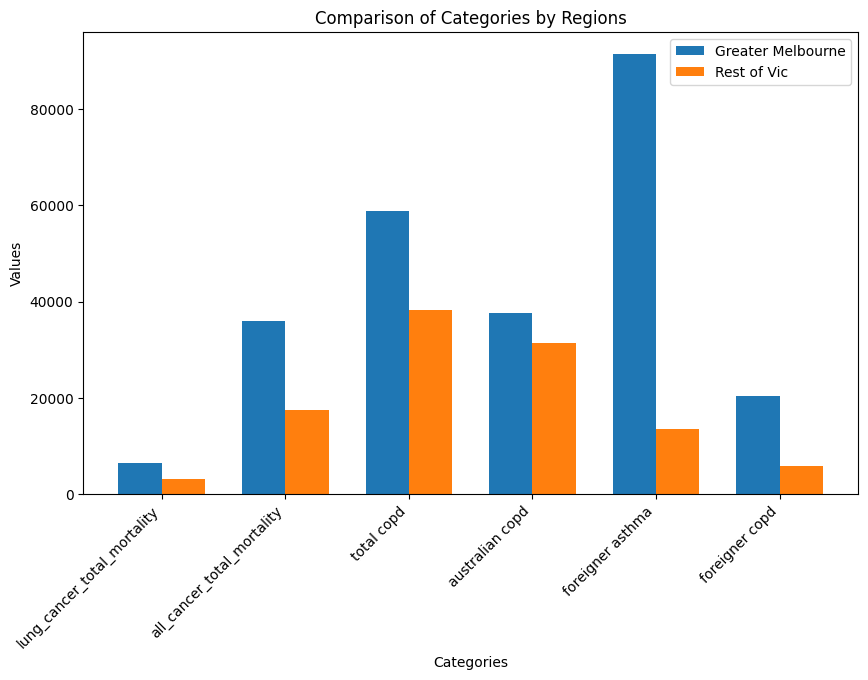

In [31]:
regions = df_plot['gccsa_name']
categories = df_plot.columns[1:]
data = df_plot.iloc[:, 1:].values

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = range(len(categories))

bar1 = ax.bar(index, data[0], bar_width, label=regions[0])
bar2 = ax.bar([i + bar_width for i in index], data[1], bar_width, label=regions[1])

ax.set_xlabel('Categories')
ax.set_ylabel('Values')
ax.set_title('Comparison of Categories by Regions')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(categories, rotation=45, ha='right')
ax.legend()

plt.show()

From the correlation analysis conducted between PM2.5 levels and lung diseases, and the comparison of lung disease categories across regions, the following conclusions can be drawn:

1. **Positive Correlation with Lung Cancer, All Cancer, and COPD Mortality:** In both Greater Melbourne and the rest of Victoria, there is a positive correlation between PM2.5 levels and mortality rates related to lung cancer, all cancer, and Chronic Obstructive Pulmonary Disease (COPD). As PM2.5 levels increase, there is a corresponding increase in mortality rates for these diseases.

2. **Higher Risk for Foreigner Populations:** Additionally, the data indicates that foreigner populations are particularly susceptible. PM2.5 levels show a positive correlation with both asthma and COPD mortality rates in foreigners, suggesting a higher risk for this demographic.

3. **Regional Livability:** Given the established link between elevated PM2.5 levels and various lung diseases, it is evident that residing in areas with lower PM2.5 levels may reduce the risk of these health issues. Therefore, from a public health perspective, residing in regions outside of Greater Melbourne, with comparatively better air quality, may be beneficial for reducing the risk of lung diseases associated with elevated PM2.5 levels.
